# Connectivity Mapping using Expert-derived Resistance Rasters

## Rasterise Focal Nodes

In [15]:
import geopandas as gpd
import rasterio

# Define file paths
species_list = ["Bufo", "Rana", "Lissotriton"]
focal_nodes_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning.shp",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning.shp",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Liss_Spawning.shp"
}
reprojected_focal_nodes_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/{species}_Spawning_Reprojected.shp"
    for species in species_list
}

# Get CRS from the resistance raster
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif"
with rasterio.open(resistance_raster_path) as src:
    resistance_crs = src.crs
    print("📌 Resistance Raster CRS:", resistance_crs)

# Loop through species and reproject focal nodes if needed
for species in species_list:
    focal_nodes = gpd.read_file(focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty!")
        continue  # Skip this species

    # Check and reproject if needed
    if focal_nodes.crs != resistance_crs:
        focal_nodes = focal_nodes.to_crs(resistance_crs)
        focal_nodes.to_file(reprojected_focal_nodes_paths[species])
        print(f"✅ {species} focal nodes reprojected and saved at: {reprojected_focal_nodes_paths[species]}")
    else:
        print(f"✅ {species} focal nodes already in {resistance_crs}. No reprojection needed.")


📌 Resistance Raster CRS: EPSG:27700
✅ Bufo focal nodes reprojected and saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Reprojected.shp
✅ Rana focal nodes reprojected and saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Reprojected.shp
✅ Lissotriton focal nodes reprojected and saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Reprojected.shp


In [16]:
import numpy as np

# Loop through each species and assign unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(reprojected_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty after reprojection!")
        continue  # Skip this species

    # Assign a unique ID to each focal node (starting from 1)
    focal_nodes["unique_id"] = np.arange(1, len(focal_nodes) + 1)

    # Save the updated shapefile
    focal_nodes.to_file(reprojected_focal_nodes_paths[species])
    print(f"✅ Unique IDs assigned and saved for {species} at {reprojected_focal_nodes_paths[species]}")


✅ Unique IDs assigned and saved for Bufo at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Reprojected.shp
✅ Unique IDs assigned and saved for Rana at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Reprojected.shp
✅ Unique IDs assigned and saved for Lissotriton at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Reprojected.shp


In [17]:
import rasterio
from rasterio.features import rasterize

# Define output raster paths
focal_nodes_raster_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}.asc"
    for species in species_list
}

# Open resistance raster to get dimensions & transform
with rasterio.open(resistance_raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    width, height = src.width, src.height
    meta.update(driver="AAIGrid", dtype=rasterio.int32, nodata=-9999)

# Rasterize focal nodes using unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty after adding unique IDs!")
        continue  # Skip this species

    # Rasterize focal nodes with unique IDs
    focal_nodes_raster = rasterize(
        [(geom, uid) for geom, uid in zip(focal_nodes.geometry, focal_nodes["unique_id"])],
        out_shape=(height, width),
        transform=transform,
        fill=-9999,  # Background should be NoData
        all_touched=True,
        dtype=rasterio.int32
    )

    # Save the raster
    with rasterio.open(focal_nodes_raster_paths[species], "w", **meta) as dst:
        dst.write(focal_nodes_raster, 1)

    print(f"✅ {species} focal nodes raster saved at: {focal_nodes_raster_paths[species]}")


✅ Bufo focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo.asc
✅ Rana focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana.asc
✅ Lissotriton focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton.asc


In [22]:
import geopandas as gpd

# Define paths
species_list = ["Bufo", "Rana", "Lissotriton"]
updated_focal_nodes_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Updated.shp",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Updated.shp",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Updated.shp"
}

# Check if shapefiles contain valid points
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])
    
    print(f"\n🔍 Checking {species} focal nodes:")
    print(f"Total points: {len(focal_nodes)}")
    print(f"First 5 geometries:\n{focal_nodes.geometry.head()}")

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is EMPTY!")



🔍 Checking Bufo focal nodes:
Total points: 42
First 5 geometries:
0     POINT (-3.61484 55.9789)
1     POINT (-4.03352 55.7823)
2     POINT (-3.67708 55.9904)
3     POINT (-3.67678 55.9638)
4    POINT (-2.98651 55.86022)
Name: geometry, dtype: geometry

🔍 Checking Rana focal nodes:
Total points: 209
First 5 geometries:
0    POINT (-3.24191 55.92728)
1     POINT (-4.11562 56.1117)
2     POINT (-3.79301 56.0164)
3    POINT (-3.95703 56.13753)
4    POINT (-4.37909 56.02189)
Name: geometry, dtype: geometry

🔍 Checking Lissotriton focal nodes:
Total points: 85
First 5 geometries:
0     POINT (-3.71319 55.9572)
1    POINT (-4.18943 55.90513)
2    POINT (-3.96218 56.18355)
3    POINT (-3.32501 55.89615)
4    POINT (-3.79808 55.99494)
Name: geometry, dtype: geometry


In [23]:
import geopandas as gpd
import numpy as np

# Define paths for updated focal node shapefiles
species_list = ["Bufo", "Rana", "Lissotriton"]
updated_focal_nodes_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Updated.shp",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Updated.shp",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Updated.shp"
}

# Loop through each species and assign unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty!")
        continue  # Skip this species

    # Assign a unique ID to each focal node (starting from 1)
    focal_nodes["unique_id"] = np.arange(1, len(focal_nodes) + 1)

    # Save the updated shapefile with unique IDs
    focal_nodes.to_file(updated_focal_nodes_paths[species])
    print(f"✅ Unique IDs assigned and saved for {species} at {updated_focal_nodes_paths[species]}")


✅ Unique IDs assigned and saved for Bufo at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Updated.shp
✅ Unique IDs assigned and saved for Rana at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Updated.shp
✅ Unique IDs assigned and saved for Lissotriton at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Updated.shp


In [24]:
import rasterio
from rasterio.features import rasterize

# Define raster output paths
focal_nodes_raster_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}.asc"
    for species in species_list
}

# Open resistance raster to match dimensions & transform
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif"
with rasterio.open(resistance_raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    width, height = src.width, src.height
    meta.update(driver="AAIGrid", dtype=rasterio.int32, nodata=-9999)

# Rasterize focal nodes using unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty after adding unique IDs!")
        continue  # Skip this species

    # Rasterize focal nodes with unique IDs
    focal_nodes_raster = rasterize(
        [(geom, uid) for geom, uid in zip(focal_nodes.geometry, focal_nodes["unique_id"])],
        out_shape=(height, width),
        transform=transform,
        fill=-9999,  # Background should be NoData
        all_touched=True,
        dtype=rasterio.int32
    )

    # Save the raster
    with rasterio.open(focal_nodes_raster_paths[species], "w", **meta) as dst:
        dst.write(focal_nodes_raster, 1)

    print(f"✅ {species} focal nodes raster saved at: {focal_nodes_raster_paths[species]}")


✅ Bufo focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo.asc
✅ Rana focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana.asc
✅ Lissotriton focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton.asc


In [26]:
import geopandas as gpd
import numpy as np

# Define paths for updated focal node shapefiles
species_list = ["Bufo", "Rana", "Lissotriton"]
updated_focal_nodes_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Updated.shp",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Updated.shp",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Updated.shp"
}

# Check if unique IDs are correctly assigned
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty!")
        continue  # Skip this species

    # Assign unique IDs (overwrite if already present)
    focal_nodes["unique_id"] = np.arange(1, len(focal_nodes) + 1)

    print(f"\n🔍 {species} Unique IDs Assigned:")
    print(focal_nodes[["geometry", "unique_id"]].head())  # Print first few rows

    # Save the updated shapefile with unique IDs
    focal_nodes.to_file(updated_focal_nodes_paths[species])
    print(f"✅ Unique IDs assigned and saved for {species} at {updated_focal_nodes_paths[species]}")



🔍 Bufo Unique IDs Assigned:
                    geometry  unique_id
0   POINT (-3.61484 55.9789)          1
1   POINT (-4.03352 55.7823)          2
2   POINT (-3.67708 55.9904)          3
3   POINT (-3.67678 55.9638)          4
4  POINT (-2.98651 55.86022)          5
✅ Unique IDs assigned and saved for Bufo at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Updated.shp

🔍 Rana Unique IDs Assigned:
                    geometry  unique_id
0  POINT (-3.24191 55.92728)          1
1   POINT (-4.11562 56.1117)          2
2   POINT (-3.79301 56.0164)          3
3  POINT (-3.95703 56.13753)          4
4  POINT (-4.37909 56.02189)          5
✅ Unique IDs assigned and saved for Rana at C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Updated.shp

🔍 Lissotriton Unique IDs Assigned:
                    geometry  unique_id
0   POINT (-3.71319 55.9572)          1
1  POINT (-4.18943 55.90513)          2
2  POINT (-3.96218 56.18355)          3
3  POINT (-3.325

In [27]:
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    print(f"\n🔍 {species} Unique IDs After Saving:")
    print(focal_nodes[["geometry", "unique_id"]].head())  # Print first few rows



🔍 Bufo Unique IDs After Saving:
                    geometry  unique_id
0   POINT (-3.61484 55.9789)          1
1   POINT (-4.03352 55.7823)          2
2   POINT (-3.67708 55.9904)          3
3   POINT (-3.67678 55.9638)          4
4  POINT (-2.98651 55.86022)          5

🔍 Rana Unique IDs After Saving:
                    geometry  unique_id
0  POINT (-3.24191 55.92728)          1
1   POINT (-4.11562 56.1117)          2
2   POINT (-3.79301 56.0164)          3
3  POINT (-3.95703 56.13753)          4
4  POINT (-4.37909 56.02189)          5

🔍 Lissotriton Unique IDs After Saving:
                    geometry  unique_id
0   POINT (-3.71319 55.9572)          1
1  POINT (-4.18943 55.90513)          2
2  POINT (-3.96218 56.18355)          3
3  POINT (-3.32501 55.89615)          4
4  POINT (-3.79808 55.99494)          5


In [28]:
import rasterio
from rasterio.features import rasterize

# Define raster output paths
focal_nodes_raster_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}_Corrected.asc"
    for species in species_list
}

# Open resistance raster to match dimensions & transform
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif"
with rasterio.open(resistance_raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    width, height = src.width, src.height
    meta.update(driver="AAIGrid", dtype=rasterio.int32, nodata=-9999)

# Rasterize focal nodes using unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(updated_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty after adding unique IDs!")
        continue  # Skip this species

    # Rasterize focal nodes with unique IDs
    focal_nodes_raster = rasterize(
        [(geom, uid) for geom, uid in zip(focal_nodes.geometry, focal_nodes["unique_id"])],
        out_shape=(height, width),
        transform=transform,
        fill=-9999,  # Background should be NoData
        all_touched=True,
        dtype=rasterio.int32
    )

    # Save the raster
    with rasterio.open(focal_nodes_raster_paths[species], "w", **meta) as dst:
        dst.write(focal_nodes_raster, 1)

    print(f"✅ {species} focal nodes raster saved at: {focal_nodes_raster_paths[species]}")


✅ Bufo focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo_Corrected.asc
✅ Rana focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana_Corrected.asc
✅ Lissotriton focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton_Corrected.asc


In [32]:
import geopandas as gpd
import rasterio

# Define paths for focal nodes and resistance raster
species_list = ["Bufo", "Rana", "Lissotriton"]
focal_nodes_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning.shp",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning.shp",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Liss_Spawning.shp"
}

# Output paths for corrected focal nodes
corrected_focal_nodes_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/{species}_Spawning_Reprojected.shp"
    for species in species_list
}

# Get CRS of resistance raster (should be EPSG:27700)
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif"
with rasterio.open(resistance_raster_path) as src:
    resistance_crs = src.crs  # Expected to be EPSG:27700
    print("📌 Resistance Raster CRS:", resistance_crs)

# Reproject each focal node dataset to match resistance raster
for species in species_list:
    focal_nodes = gpd.read_file(focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty!")
        continue  # Skip this species

    print(f"📌 {species} Original CRS:", focal_nodes.crs)

    # Check if reprojecting is necessary
    if focal_nodes.crs != resistance_crs:
        focal_nodes = focal_nodes.to_crs(resistance_crs)
        focal_nodes.to_file(corrected_focal_nodes_paths[species])
        print(f"✅ {species} focal nodes reprojected and saved to {corrected_focal_nodes_paths[species]}")
    else:
        print(f"✅ {species} focal nodes already in EPSG:27700. No reprojection needed.")


📌 Resistance Raster CRS: EPSG:27700
📌 Bufo Original CRS: EPSG:4326
✅ Bufo focal nodes reprojected and saved to C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Bufo_Spawning_Reprojected.shp
📌 Rana Original CRS: EPSG:4326
✅ Rana focal nodes reprojected and saved to C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Rana_Spawning_Reprojected.shp
📌 Lissotriton Original CRS: EPSG:4326
✅ Lissotriton focal nodes reprojected and saved to C:/GIS_Course/MScThesis-MaviSantarelli/data/FocalNodes/Lissotriton_Spawning_Reprojected.shp


In [33]:
for species in species_list:
    focal_nodes = gpd.read_file(corrected_focal_nodes_paths[species])

    if not focal_nodes.empty:
        minx, miny, maxx, maxy = focal_nodes.total_bounds
        print(f"\n🔍 {species} Focal Nodes Bounds After Reprojection: {minx, miny, maxx, maxy}")

        with rasterio.open(resistance_raster_path) as src:
            bounds = src.bounds  # (left, bottom, right, top)
            print("📌 Resistance Raster Bounds:", bounds)

            if minx > bounds.right or maxx < bounds.left or miny > bounds.top or maxy < bounds.bottom:
                print(f"🚨 ERROR: {species} focal nodes are STILL OUTSIDE the raster bounds!")
            else:
                print(f"✅ {species} focal nodes are NOW WITHIN the raster bounds.")



🔍 Bufo Focal Nodes Bounds After Reprojection: (217123.67060554033, 559025.6759937551, 350728.2397968053, 707815.157290967)
📌 Resistance Raster Bounds: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
✅ Bufo focal nodes are NOW WITHIN the raster bounds.

🔍 Rana Focal Nodes Bounds After Reprojection: (213846.08251791834, 564522.4841949, 364722.2871047491, 729698.7260344587)
📌 Resistance Raster Bounds: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
✅ Rana focal nodes are NOW WITHIN the raster bounds.

🔍 Lissotriton Focal Nodes Bounds After Reprojection: (216971.23106733826, 565297.9804688082, 362917.61280070944, 711667.4652093127)
📌 Resistance Raster Bounds: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
✅ Lissotriton focal nodes are NOW WITHIN the raster bounds.


In [36]:
import rasterio
from rasterio.features import rasterize

# Define raster output paths
focal_nodes_raster_paths = {
    species: f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}.asc"
    for species in species_list
}

# Open resistance raster to get dimensions & transform
with rasterio.open(resistance_raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    width, height = src.width, src.height
    meta.update(driver="AAIGrid", dtype=rasterio.int32, nodata=-9999)

# Rasterize focal nodes using unique IDs
for species in species_list:
    focal_nodes = gpd.read_file(corrected_focal_nodes_paths[species])

    if focal_nodes.empty:
        print(f"🚨 ERROR: {species} focal nodes shapefile is empty after reprojection!")
        continue  # Skip this species

    # Assign unique IDs (overwrite if necessary)
    focal_nodes["unique_id"] = range(1, len(focal_nodes) + 1)

    # Rasterize focal nodes with unique IDs
    focal_nodes_raster = rasterize(
        [(geom, uid) for geom, uid in zip(focal_nodes.geometry, focal_nodes["unique_id"])],
        out_shape=(height, width),
        transform=transform,
        fill=-9999,  # Background should be NoData
        all_touched=True,
        dtype=rasterio.int32
    )

    # Save the raster
    with rasterio.open(focal_nodes_raster_paths[species], "w", **meta) as dst:
        dst.write(focal_nodes_raster, 1)

    print(f"✅ {species} focal nodes raster saved at: {focal_nodes_raster_paths[species]}")


✅ Bufo focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo.asc
✅ Rana focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana.asc
✅ Lissotriton focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton.asc


In [37]:
for species in species_list:
    focal_nodes_raster_path = focal_nodes_raster_paths[species]

    with rasterio.open(focal_nodes_raster_path) as src:
        focal_nodes_data = src.read(1)
        unique_values = np.unique(focal_nodes_data)
        print(f"🔍 Unique values in {species} focal node raster:", unique_values)


🔍 Unique values in Bufo focal node raster: [-9999     1     2     3     6     8    10    11    12    13    14    15
    16    17    18    19    20    21    22    23    24    25    26    27
    28    29    30    31    32    33    34    35    36    37    38    39
    40    41    42]
🔍 Unique values in Rana focal node raster: [-9999     1     3     4     5     6     9    12    14    15    17    18
    19    21    22    23    26    27    29    30    31    32    34    35
    36    37    38    39    41    42    43    44    45    48    50    51
    52    53    54    55    56    60    61    62    63    65    66    67
    69    70    71    73    74    75    76    77    78    79    80    81
    82    83    84    86    87    88    89    90    91    92    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   133
   134   135   136

In [3]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import mapping

# Define file paths
input_shapefile = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\FocalNodes\Rana_Spawns.shp"
output_shapefile = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\FocalNodes\Rana_Spawns_Processed.shp"
output_asc_file = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\FocalNodes\Rana_Spawns.asc"

# Load the focal nodes
focal_nodes = gpd.read_file(input_shapefile)

# Check if the file is empty
if focal_nodes.empty:
    raise ValueError("🚨 ERROR: The focal nodes shapefile is empty!")

# Assign unique IDs to each focal node
focal_nodes["ID"] = range(1, len(focal_nodes) + 1)

# Get CRS & resolution from the resistance raster
resistance_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Resistance\Resistance_Categorical_Bufo.tif"
with rasterio.open(resistance_raster_path) as src:
    resistance_crs = src.crs
    resolution = src.res[0]  # Assuming square pixels
    raster_transform = src.transform
    raster_shape = (src.height, src.width)
    print("📌 Resistance Raster CRS:", resistance_crs)
    print("📌 Raster Resolution:", resolution)

# Ensure focal nodes match resistance raster CRS
if focal_nodes.crs != resistance_crs:
    focal_nodes = focal_nodes.to_crs(resistance_crs)

# Save reprojected focal nodes with unique IDs
focal_nodes.to_file(output_shapefile)
print(f"✅ Reprojected focal nodes saved at: {output_shapefile}")

# Convert to raster format (ASCII)
# Prepare rasterization
rasterized_nodes = [
    (mapping(geom), id) for geom, id in zip(focal_nodes.geometry, focal_nodes["ID"])
]

# Rasterize and save as ASCII (.asc)
with rasterio.open(
    output_asc_file, "w",
    driver="AAIGrid", 
    height=raster_shape[0], width=raster_shape[1],
    count=1, dtype=rasterio.int32,
    crs=resistance_crs, transform=raster_transform,
    nodata=-9999  # Set a no-data value
) as dst:
    rasterized_array = rasterize(
        rasterized_nodes,
        out_shape=raster_shape,
        transform=raster_transform,
        fill=-9999
    )
    dst.write(rasterized_array, 1)

print(f"✅ Rasterized focal nodes saved in ASCII format at: {output_asc_file}")


📌 Resistance Raster CRS: EPSG:27700
📌 Raster Resolution: 30.0
✅ Reprojected focal nodes saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\FocalNodes\Rana_Spawns_Processed.shp
✅ Rasterized focal nodes saved in ASCII format at: C:\GIS_Course\MScThesis-MaviSantarelli\results\FocalNodes\Rana_Spawns.asc


In [4]:
import rasterio
import numpy as np

# Define the ASCII raster file path
asc_file = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\FocalNodes\Rana_Spawns.asc"

# Open the raster and read data
with rasterio.open(asc_file) as src:
    raster_data = src.read(1)  # Read the first (and only) band
    unique_values = np.unique(raster_data)

# Remove nodata value (-9999) from the list
unique_values = unique_values[unique_values != -9999]

# Display unique values
print(f"✅ Unique values in the raster (excluding nodata): {unique_values}")
print(f"🔢 Total unique focal nodes detected: {len(unique_values)}")


✅ Unique values in the raster (excluding nodata): [ 2  4  5  6  7  8  9 10 11 12 13 15 17 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
🔢 Total unique focal nodes detected: 41


## Resistance Rasters Conversion

In [18]:
import rasterio
import numpy as np

# Define resistance raster paths
resistance_raster_paths = {
    "Bufo": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_double.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo_double.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double.tif"
    },
    "Rana": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_double.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana_double.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana_double.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana_double.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_double.tif"
    },
    "Lissotriton": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton_double.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton_double.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Lissotriton_double.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton_double.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton_double.tif"
    }
}

# Convert each `.tif` resistance raster to `.asc`
for species, methods in resistance_raster_paths.items():
    for method, raster_path in methods.items():
        with rasterio.open(raster_path) as src:
            meta = src.meta.copy()
            data = src.read(1).astype(np.float64)  # Ensure float64 precision

            # Update metadata for ASCII Grid format
            meta.update(driver="AAIGrid", dtype="float64")

            # Save the `.asc` file
            converted_raster_path = raster_path.replace(".tif", ".asc")
            with rasterio.open(converted_raster_path, "w", **meta) as dst:
                dst.write(data, 1)

            print(f"✅ Converted {raster_path} to {converted_raster_path}")


✅ Converted C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_double.tif to C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_double.asc
✅ Converted C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double.tif to C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double.asc
✅ Converted C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo_double.tif to C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo_double.asc
✅ Converted C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double.tif to C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double.asc
✅ Converted C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double.tif to C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double.a

In [20]:
import os

# Define paths for the converted `.asc` resistance rasters
species_list = ["Bufo", "Rana", "Lissotriton"]
resistance_methods = ["Categorical", "Log", "Inv", "Linear", "Exponential"]

# Check existence of each `.asc` file
for species in species_list:
    for method in resistance_methods:
        raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double.asc"
        if os.path.exists(raster_path):
            print(f"✅ Found: {raster_path}")
        else:
            print(f"🚨 MISSING FILE: {raster_path}")


✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana_double.asc
✅ Found: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponentia

In [1]:
import rasterio
import numpy as np

# Define resistance raster paths for all species
species_list = ["Bufo", "Rana", "Lissotriton"]
resistance_methods = ["Categorical", "Log", "Inv", "Linear", "Exponential"]

# Check each raster for zero values
for species in species_list:
    for method in resistance_methods:
        raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double.asc"
        
        with rasterio.open(raster_path) as src:
            data = src.read(1)
            zero_count = np.sum(data == 0)
            
            print(f"🔍 {species} - {method} - Zero values found: {zero_count}")


🔍 Bufo - Categorical - Zero values found: 0
🔍 Bufo - Log - Zero values found: 15335595
🔍 Bufo - Inv - Zero values found: 0
🔍 Bufo - Linear - Zero values found: 2511278
🔍 Bufo - Exponential - Zero values found: 5378836
🔍 Rana - Categorical - Zero values found: 0
🔍 Rana - Log - Zero values found: 15343369
🔍 Rana - Inv - Zero values found: 0
🔍 Rana - Linear - Zero values found: 2511278
🔍 Rana - Exponential - Zero values found: 5733067
🔍 Lissotriton - Categorical - Zero values found: 0
🔍 Lissotriton - Log - Zero values found: 15335595
🔍 Lissotriton - Inv - Zero values found: 0
🔍 Lissotriton - Linear - Zero values found: 2511278
🔍 Lissotriton - Exponential - Zero values found: 5299299


In [11]:
import rasterio
import numpy as np

# Define species and resistance methods
species_list = ["Bufo", "Rana", "Lissotriton"]
resistance_methods = ["Log", "Linear", "Exponential"]

# Check NoData values in each `.asc` file
for species in species_list:
    for method in resistance_methods:
        raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double.asc"

        with rasterio.open(raster_path) as src:
            data = src.read(1)
            nodata_value = src.nodata  # Get NoData value from metadata

            # Count NoData values
            nodata_count = np.sum(data == nodata_value)
            print(f"🔍 {species} - {method} - NoData Values Found: {nodata_count} (NoData Value: {nodata_value})")


🔍 Bufo - Log - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Bufo - Linear - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Bufo - Exponential - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Rana - Log - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Rana - Linear - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Rana - Exponential - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Lissotriton - Log - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Lissotriton - Linear - NoData Values Found: 19561306 (NoData Value: -32768.0)
🔍 Lissotriton - Exponential - NoData Values Found: 19561306 (NoData Value: -32768.0)


In [12]:
# Define replacement value
zero_replacement = 0.001  # Smallest possible resistance to avoid zero errors

# Process each raster
for species in species_list:
    for method in resistance_methods:
        raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double.asc"

        with rasterio.open(raster_path) as src:
            meta = src.meta.copy()
            data = src.read(1)
            nodata_value = src.nodata  # Get NoData value

            # Replace zero values (but keep NoData intact)
            zero_count = np.sum((data == 0) & (data != nodata_value))
            if zero_count > 0:
                data[data == 0] = zero_replacement  # Replace only zeros, keep NoData

                # Save the corrected raster
                corrected_raster_path = raster_path.replace(".asc", "_corrected.asc")
                meta.update(dtype="float64")

                with rasterio.open(corrected_raster_path, "w", **meta) as dst:
                    dst.write(data, 1)

                print(f"✅ Replaced {zero_count} zero values in {corrected_raster_path}")


✅ Replaced 15335595 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double_corrected.asc
✅ Replaced 2511278 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double_corrected.asc
✅ Replaced 5378836 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double_corrected.asc
✅ Replaced 15343369 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana_double_corrected.asc
✅ Replaced 2511278 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana_double_corrected.asc
✅ Replaced 5733067 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_double_corrected.asc
✅ Replaced 15335595 zero values in C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton_double_corrected.asc
✅ Replaced 2511278 zero values in C:/

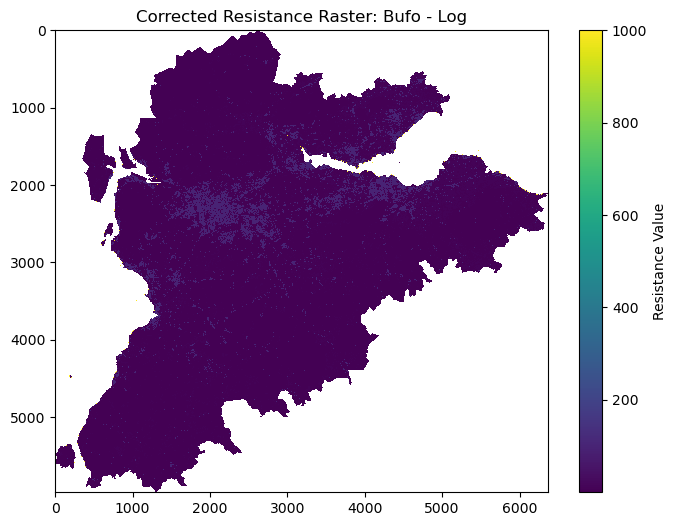

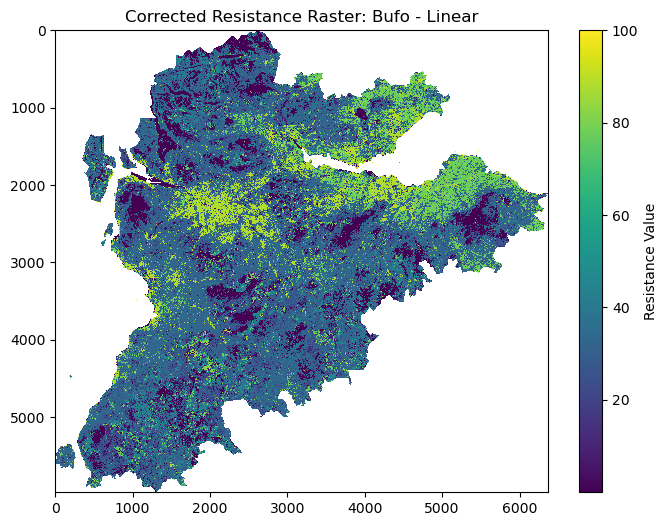

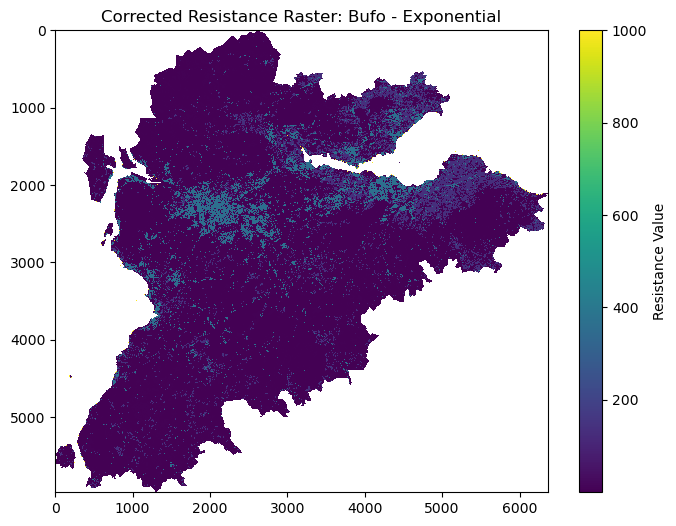

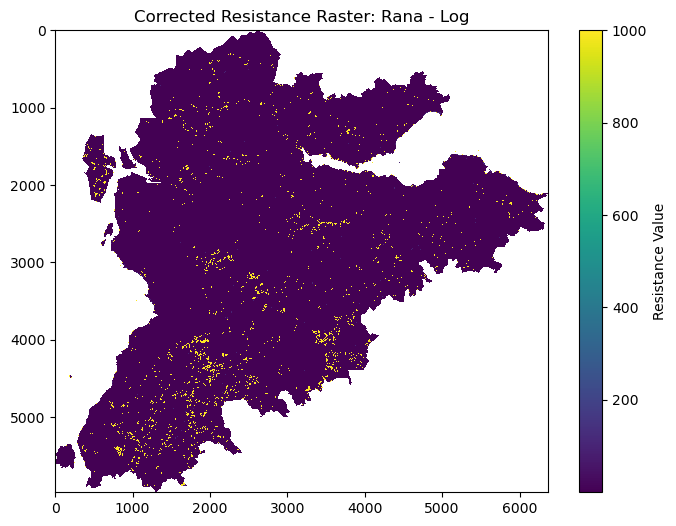

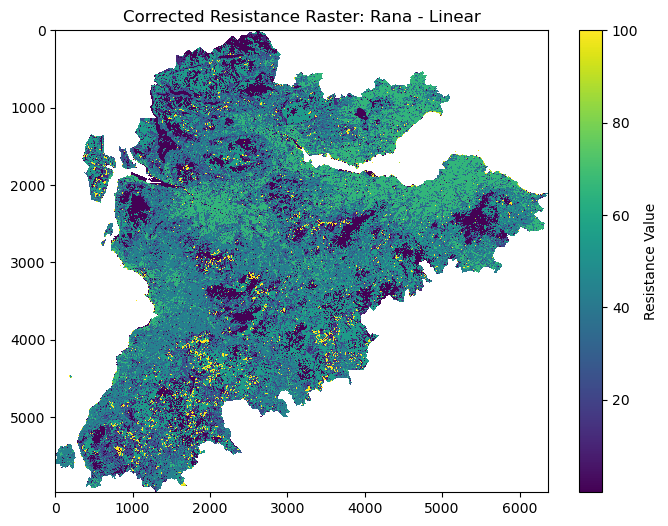

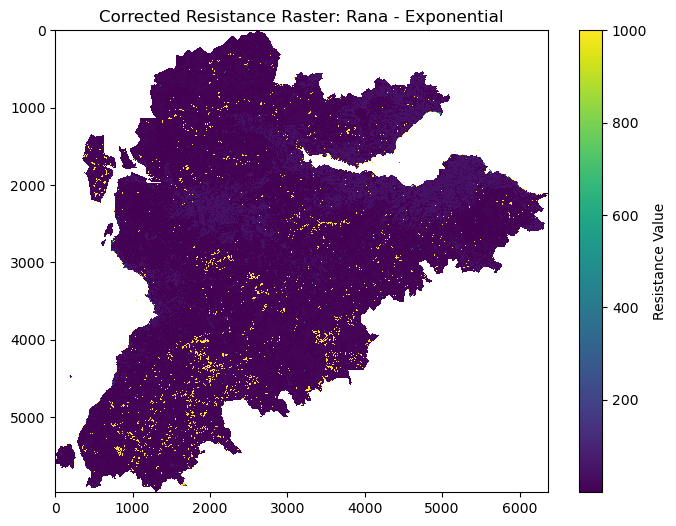

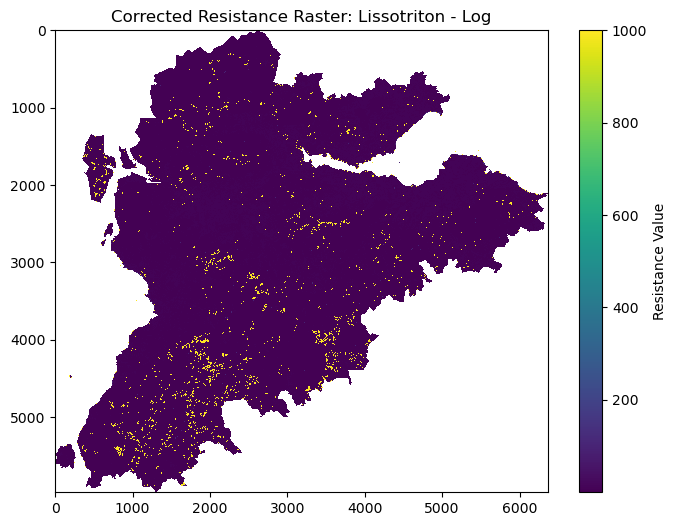

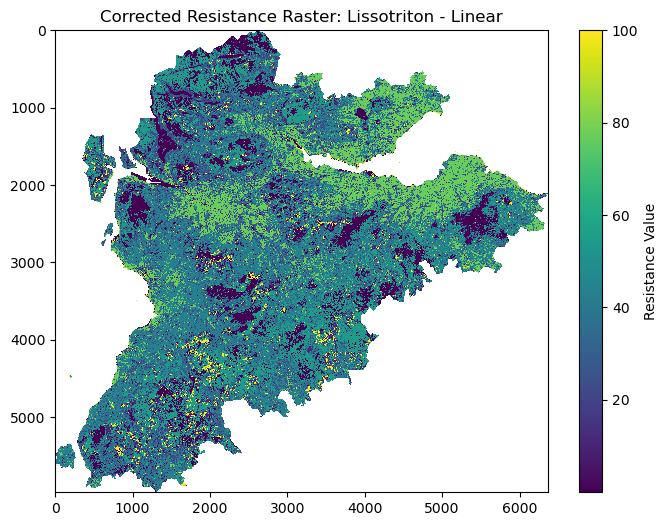

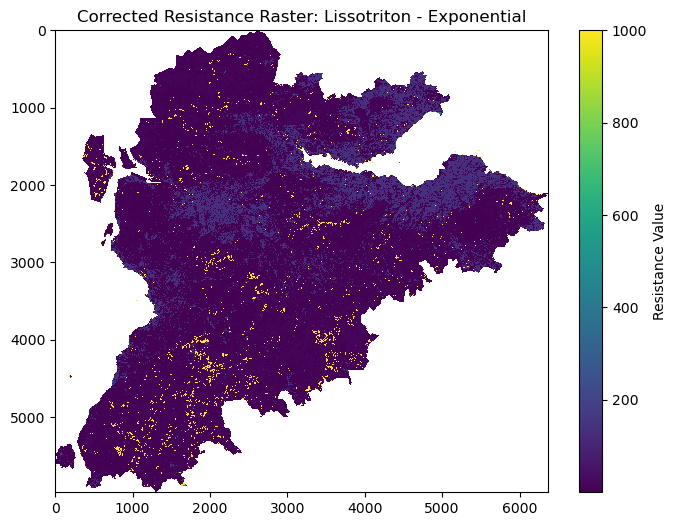

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define species and resistance methods
species_list = ["Bufo", "Rana", "Lissotriton"]
resistance_methods = ["Log", "Linear", "Exponential"]

# Plot each corrected raster
for species in species_list:
    for method in resistance_methods:
        raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double_corrected.asc"

        with rasterio.open(raster_path) as src:
            data = src.read(1)
            nodata_value = src.nodata  # Get NoData value

            # Mask NoData values for plotting
            masked_data = np.ma.masked_where(data == nodata_value, data)

            # Plot raster
            plt.figure(figsize=(8, 6))
            plt.imshow(masked_data, cmap="viridis", interpolation="nearest")
            plt.colorbar(label="Resistance Value")
            plt.title(f"Corrected Resistance Raster: {species} - {method}")
            plt.show()


## Create Configuration Files

In [23]:
import os

# Update `.ini` files to reference `.asc` files
for species in species_list:
    for method in resistance_methods:
        ini_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/{species}_{method}.ini"

        # Correct `.asc` file paths
        resistance_raster_asc = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double.asc"
        focal_node_asc = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}_Corrected.asc"

        # Circuitscape Configuration
        config = f"""[Circuitscape]
data_type = raster
scenario = pairwise

[Habitat raster or graph]
habitat_file = {resistance_raster_asc}
habitat_map_is_resistances = True

[Options for pairwise and one-to-all and all-to-one modes]
point_file = {focal_node_asc}

[Output options]
output_file = C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/{species}_{method}_output
write_cur_maps = False
write_volt_maps = False
write_cum_cur_map_only = True
write_max_cur_maps = False
log_transform_maps = False
set_null_currents_to_nodata = False
set_null_voltages_to_nodata = False
compress_grids = False

[Calculation options]
low_memory_mode = False
solver = cg+amg
print_timings = False

[Connection scheme for raster habitat data]
connect_four_neighbors_only = False
connect_using_avg_resistances = False

[Short circuit regions (aka polygons)]
use_polygons = False

[Options for one-to-all and all-to-one modes]
use_variable_source_strengths = False
variable_source_file = None

[Mask file]
use_mask = False
mask_file = None
"""
        # Save the updated `.ini` file
        with open(ini_path, "w") as file:
            file.write(config)

        print(f"✅ Updated `.ini` file: {ini_path}")


✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Categorical.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Log.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Inv.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Linear.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Exponential.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Categorical.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Log.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Inv.ini
✅ Updated `.ini` file: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Linear.ini
✅ Updated `.ini` file: C:/GIS_Cour

In [22]:
import rasterio

# Check alignment for each species
for species in species_list:
    resistance_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_{species}_double.asc"
    focal_node_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_{species}_Corrected.asc"

    with rasterio.open(resistance_path) as res_src, rasterio.open(focal_node_path) as fnode_src:
        res_bounds, res_res, res_crs = res_src.bounds, res_src.res, res_src.crs
        fnode_bounds, fnode_res, fnode_crs = fnode_src.bounds, fnode_src.res, fnode_src.crs

        print(f"\n🔍 Checking {species}:")
        print(f"   ✅ Resistance CRS: {res_crs}")
        print(f"   ✅ Focal Node CRS: {fnode_crs}")
        print(f"   ✅ Resistance Extent: {res_bounds}")
        print(f"   ✅ Focal Node Extent: {fnode_bounds}")
        print(f"   ✅ Resistance Resolution: {res_res}")
        print(f"   ✅ Focal Node Resolution: {fnode_res}")

        if res_crs != fnode_crs:
            print(f"🚨 ERROR: CRS mismatch for {species}!")

        if res_bounds != fnode_bounds:
            print(f"🚨 ERROR: Extent mismatch for {species}!")

        if res_res != fnode_res:
            print(f"🚨 ERROR: Resolution mismatch for {species}!")



🔍 Checking Bufo:
   ✅ Resistance CRS: EPSG:27700
   ✅ Focal Node CRS: EPSG:27700
   ✅ Resistance Extent: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
   ✅ Focal Node Extent: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
   ✅ Resistance Resolution: (30.0, 30.0)
   ✅ Focal Node Resolution: (30.0, 30.0)

🔍 Checking Rana:
   ✅ Resistance CRS: EPSG:27700
   ✅ Focal Node CRS: EPSG:27700
   ✅ Resistance Extent: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
   ✅ Focal Node Extent: BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
   ✅ Resistance Resolution: (30.0, 30.0)
   ✅ Focal Node Resolution: (30.0, 30.0)

🔍 Checking Lissotriton:
   ✅ Resistance CRS: EPSG:27700
   ✅ Focal Node CRS: EPSG:27700
   ✅ Resistance Extent: BoundingBox(lef

In [2]:
import os

# Define base directory for Circuitscape configurations
base_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs"
os.makedirs(base_dir, exist_ok=True)

# Define species and resistance models
species_list = ["Bufo", "Rana", "Lissotriton"]
resistance_types = ["Log", "Inv", "Linear", "Exponential", "Categorical"]

# Define resistance raster paths (adjust paths if needed)
resistance_raster_paths = {
    "Bufo": {
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo.tif",
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif"
    },
    "Rana": {
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana.tif",
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana.tif"
    },
    "Lissotriton": {
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Lissotriton.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton.tif",
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton.tif"
    }
}

# Define focal node raster paths
focal_node_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo.asc",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana.asc",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton.asc"
}


In [3]:
import os

# Create Circuitscape `.ini` file for each species & resistance type
for species in species_list:
    for resistance in resistance_types:
        # Define output `.ini` file path
        ini_path = os.path.join(base_dir, f"{species}_{resistance}.ini")
        
        # Optimized Circuitscape Configuration
        config = f"""[Circuitscape]
data_type = raster
scenario = pairwise

[Habitat raster or graph]
habitat_file = {resistance_raster_paths[species][resistance]}
habitat_map_is_resistances = True

[Options for pairwise and one-to-all and all-to-one modes]
point_file = {focal_node_paths[species]}

[Output options]
output_file = {base_dir}/{species}_{resistance}_output
write_cur_maps = False 
write_volt_maps = False
write_cum_cur_map_only = True
write_max_cur_maps = False
log_transform_maps = False
set_null_currents_to_nodata = False
set_null_voltages_to_nodata = False
compress_grids = False

[Calculation options]
low_memory_mode = False
solver = cholmod 
print_timings = False

[Connection scheme for raster habitat data]
connect_four_neighbors_only = False
connect_using_avg_resistances = False

[Short circuit regions (aka polygons)]
use_polygons = False

[Options for one-to-all and all-to-one modes]
use_variable_source_strengths = False
variable_source_file = None

[Mask file]
use_mask = False
mask_file = None
"""
        # Save `.ini` file
        with open(ini_path, "w") as file:
            file.write(config)
        
        print(f"✅ Optimized Circuitscape config saved: {ini_path}")


✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Log.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Inv.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Linear.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Exponential.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Categorical.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Rana_Log.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Rana_Inv.ini
✅ Optimized Circuitscape config saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Rana_Linear.ini
✅ Optimized Circui

In [13]:
import rasterio
import numpy as np

# Define resistance raster paths for all species & methods
resistance_raster_paths = {
    "Bufo": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo.tif"
    },
    "Rana": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana.tif"
    },
    "Lissotriton": {
        "Categorical": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton.tif",
        "Log": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton.tif",
        "Inv": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Lissotriton.tif",
        "Linear": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif",
        "Exponential": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton.tif"
    }
}

# Convert each resistance raster to float64
for species, methods in resistance_raster_paths.items():
    for method, raster_path in methods.items():
        with rasterio.open(raster_path) as src:
            meta = src.meta.copy()
            data = src.read(1).astype(np.float64)  # Convert to float64

            # Update metadata for float64
            meta.update(dtype="float64")

            # Save the converted raster
            converted_raster_path = raster_path.replace(".tif", "_double.tif")
            with rasterio.open(converted_raster_path, "w", **meta) as dst:
                dst.write(data, 1)

            print(f"✅ Converted {species} - {method} to double precision: {converted_raster_path}")


✅ Converted Bufo - Categorical to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_double.tif
✅ Converted Bufo - Log to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo_double.tif
✅ Converted Bufo - Inv to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo_double.tif
✅ Converted Bufo - Linear to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo_double.tif
✅ Converted Bufo - Exponential to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_double.tif
✅ Converted Rana - Categorical to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_double.tif
✅ Converted Rana - Log to double precision: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana_double.tif
✅ Converted Ran

In [9]:
import rasterio

# Define the focal node raster paths
focal_nodes_raster_paths = [
    "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo_Corrected.asc",
    "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana_Corrected.asc",
    "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton_Corrected.asc"
]

# Check the data type of each focal node raster
for raster_path in focal_nodes_raster_paths:
    with rasterio.open(raster_path) as src:
        print(f"📌 {raster_path} - Data Type: {src.dtypes[0]}")


📌 C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo_Corrected.asc - Data Type: int32
📌 C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana_Corrected.asc - Data Type: int32
📌 C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton_Corrected.asc - Data Type: int32


In [10]:
import rasterio
import numpy as np

# Convert focal node rasters to float64
for raster_path in focal_nodes_raster_paths:
    with rasterio.open(raster_path) as src:
        meta = src.meta.copy()
        data = src.read(1).astype(np.float64)  # Convert to float64

        # Update metadata
        meta.update(dtype="float64")

        # Save new raster
        converted_raster_path = raster_path.replace(".asc", "_double.asc")
        with rasterio.open(converted_raster_path, "w", **meta) as dst:
            dst.write(data, 1)

        print(f"✅ Converted to float64: {converted_raster_path}")


✅ Converted to float64: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo_Corrected_double.asc
✅ Converted to float64: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana_Corrected_double.asc
✅ Converted to float64: C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton_Corrected_double.asc


In [15]:
# Define focal node raster paths as a dictionary
focal_nodes_raster_paths = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Bufo_Corrected.asc",
    "Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Rana_Corrected.asc",
    "Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/FocalNodes/Focal_Nodes_Lissotriton_Corrected.asc"
}


In [17]:
import os

# Update `.ini` files with a new solver
for species in resistance_raster_paths:
    for resistance in resistance_raster_paths[species]:
        ini_path = os.path.join(base_dir, f"{species}_{resistance}.ini")

        # Use `cg+amg` for better performance on large graphs
        config = f"""[Circuitscape]
data_type = raster
scenario = pairwise

[Habitat raster or graph]
habitat_file = {resistance_raster_paths[species][resistance].replace(".tif", "_double.tif")}
habitat_map_is_resistances = True

[Options for pairwise and one-to-all and all-to-one modes]
point_file = {focal_nodes_raster_paths[species].replace(".asc", "_double.asc")}

[Output options]
output_file = {base_dir}/{species}_{resistance}_output
write_cur_maps = False
write_volt_maps = False
write_cum_cur_map_only = True
write_max_cur_maps = False
log_transform_maps = False
set_null_currents_to_nodata = False
set_null_voltages_to_nodata = False
compress_grids = False

[Calculation options]
low_memory_mode = False
solver = cg+amg  # Switching solver for better performance
print_timings = False

[Connection scheme for raster habitat data]
connect_four_neighbors_only = False
connect_using_avg_resistances = False

[Short circuit regions (aka polygons)]
use_polygons = False

[Options for one-to-all and all-to-one modes]
use_variable_source_strengths = False
variable_source_file = None

[Mask file]
use_mask = False
mask_file = None
"""
        with open(ini_path, "w") as file:
            file.write(config)

        print(f"✅ Updated `.ini` file with `cg+amg` solver: {ini_path}")


✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Categorical.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Log.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Inv.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Linear.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Bufo_Exponential.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Rana_Categorical.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs\Rana_Log.ini
✅ Updated `.ini` file with `cg+amg` solver: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuit

In [15]:
# Update `.ini` files to reference corrected rasters
for species in ["Bufo", "Rana", "Lissotriton"]:
    for method in ["Log", "Linear", "Exponential"]:
        ini_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/{species}_{method}.ini"

        # Replace `.asc` with `_corrected.asc`
        corrected_raster_path = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_{method}_{species}_double_corrected.asc"

        # Read and modify the `.ini` file
        with open(ini_path, "r") as file:
            ini_content = file.read()

        # Replace old raster path with the corrected one
        ini_content = ini_content.replace(f"Resistance_{method}_{species}_double.asc", corrected_raster_path)

        # Save the updated `.ini` file
        with open(ini_path, "w") as file:
            file.write(ini_content)

        print(f"✅ Updated `.ini` file to use corrected resistance raster: {ini_path}")


✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Log.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Linear.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Bufo_Exponential.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Log.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Linear.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Rana_Exponential.ini
✅ Updated `.ini` file to use corrected resistance raster: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Configs/Lissotriton_Log.in